In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsBequestModel import (
    BequestWarmGlowPortfolioType,
    init_accidental_bequest,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
# First define the portfolio params similar to the notebook solution for that agent type
ConsPortfolioDict = {
    # Parameters shared with the Perfect foresight consumer type
    "CRRA": 5.0,  # Coefficient of relative risk aversion,
    "Rfree": 1.03,  # Interest factor on assets
    "DiscFac": 0.90,  # Intertemporal discount factor
    "LivPrb": [0.98],  # Survival probability
    "PermGroFac": [1.01],  # Permanent income growth factor
    "BoroCnstArt": 0.0,  # Artificial borrowing constraint
    # Maximum number of grid points to allow in cFunc (should be large)
    "MaxKinks": 400,
    # Number of agents of this type (only matters for simulation)
    "AgentCount": 10000,
    # Mean of log initial assets (only matters for simulation)
    "aNrmInitMean": 0.0,
    # Standard deviation of log initial assets (only for simulation)
    "aNrmInitStd": 1.0,
    # Mean of log initial permanent income (only matters for simulation)
    "pLvlInitMean": 0.0,
    # Standard deviation of log initial permanent income (only matters for simulation)
    "pLvlInitStd": 0.0,
    # Aggregate permanent income growth factor: portion of PermGroFac attributable to aggregate productivity growth (only matters for simulation)
    "PermGroFacAgg": 1.0,
    "T_age": None,  # Age after which simulated agents are automatically killed
    "T_cycle": 1,  # Number of periods in the cycle for this agent type
    "PerfMITShk": False,  # Do Perfect Foresight MIT Shock: Forces Newborns to follow solution path of the agent he/she replaced when True
    # assets above grid parameters
    "aXtraMin": 0.001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 100,  # Maximum end-of-period "assets above minimum" value
    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraNestFac": 1,
    "aXtraCount": 200,  # Number of points in the grid of "assets above minimum"
    "aXtraExtra": [
        None,
    ],  # Some other value of "assets above minimum" to add to the grid, not used
    # Income process variables
    "PermShkStd": [0.1],  # Standard deviation of log permanent income shocks
    "PermShkCount": 7,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.1],  # Standard deviation of log transitory income shocks
    "TranShkCount": 7,  # Number of points in discrete approximation to transitory income shocks
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "UnempPrbRet": 0.005,  # Probability of "unemployment" while retired
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "tax_rate": 0.0,  # Flat income tax rate
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    "vFuncBool": False,  # Whether to calculate the value function during solution
    # Use cubic spline interpolation when True, linear interpolation when False
    "CubicBool": False,
    # Use permanent income neutral measure (see Harmenberg 2021) during simulations when True.
    "neutral_measure": False,
    # Whether Newborns have transitory shock. The default is False.
    "NewbornTransShk": False,
    # Attributes specific to the Portfolio consumer
    "RiskyAvg": 1.08,  # Average return of the risky asset
    "RiskyStd": 0.20,  # Standard deviation of (log) risky returns
    "RiskyCount": 5,  # Number of integration nodes to use in approximation of risky returns
    "ShareCount": 25,  # Number of discrete points in the risky share approximation
    # Probability that the agent can adjust their risky portfolio share each period
    "AdjustPrb": 1.0,
    # Flag for whether to optimize risky share on a discrete grid only
    "DiscreteShareBool": False,
}

In [3]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to,
    age=birth_age,
    education=education,
    wave=1995,
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    min_age=birth_age,
    max_age=death_age - 1,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

portfolio_params = {  # Attributes specific to the Portfolio consumer
    "RiskyAvg": 1.08,  # Average return of the risky asset
    "RiskyStd": 0.20,  # Standard deviation of (log) risky returns
    "RiskyCount": 5,  # Number of integration nodes to use in approximation of risky returns
    "ShareCount": 25,  # Number of discrete points in the risky share approximation
    # Probability that the agent can adjust their risky portfolio share each period
    "AdjustPrb": 1.0,
    "DiscreteShareBool": False,
}

# Update all the new parameters
params = copy(init_accidental_bequest)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update(portfolio_params)
params.update({"LivPrb": [1.0] * len(liv_prb)})

In [4]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
TerminalExample = BequestWarmGlowPortfolioType(**params)
# Make this consumer live a sequence of periods exactly once
TerminalExample.cycles = 1
print(TerminalExample.BeqFac)

0.0


In [5]:
start_time = time()
TerminalExample.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
TerminalExample.unpack("cFuncAdj")

Solving a lifecycle consumer took 0.37440013885498047 seconds.


Consumption functions


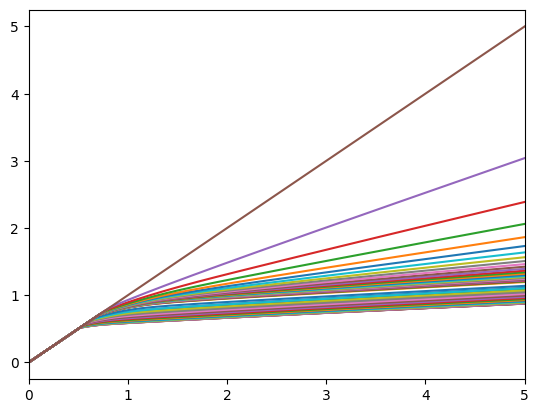

In [6]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(TerminalExample.cFuncAdj, 0, 5)

In [7]:
# Number of LifecycleExamples and periods in the simulation.
TerminalExample.AgentCount = 500
TerminalExample.T_sim = 200

# Set up the variables we want to keep track of.
TerminalExample.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
TerminalExample.initialize_sim()
TerminalExample.simulate()

{'aNrm': array([[ 0.40559186,  0.85264607,  0.42896729, ...,  1.73970491,
          3.93266861,  0.28371063],
        [ 0.16451866,  0.61940958,  1.26515298, ...,  1.18982694,
          2.88857877,  1.19090892],
        [ 0.13993554,  0.82889289,  1.10211732, ...,  0.38780635,
          1.72459078,  0.88437069],
        ...,
        [ 2.28734298,  1.00534369,  1.84044623, ...,  0.46889557,
          5.12981426,  0.48866757],
        [ 2.39150509,  0.67278008,  1.11446174, ...,  1.03338779,
          7.79060462,  1.20471905],
        [ 3.28471081,  1.41493134,  1.70118576, ...,  0.72038464,
         10.51748237,  1.94688479]]),
 'cNrm': array([[0.78166446, 0.83758056, 0.78532984, ..., 0.92471425, 1.113275  ,
         0.75858695],
        [0.71510617, 0.79872336, 0.86527561, ..., 0.85803081, 1.00903376,
         0.85813533],
        [0.70101547, 0.81306001, 0.83988011, ..., 0.76088548, 0.89686078,
         0.81865241],
        ...,
        [0.94566252, 0.8305746 , 0.90709927, ..., 0.7724

In [8]:
raw_data = {
    "Age": TerminalExample.history["t_age"].flatten() + birth_age - 1,
    "pIncome": TerminalExample.history["pLvl"].flatten(),
    "nrmM": TerminalExample.history["mNrm"].flatten(),
    "nrmC": TerminalExample.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

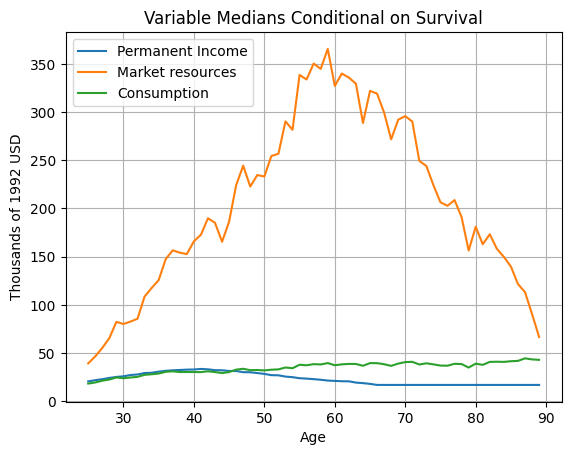

In [9]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()